In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pathlib
import scipy
import warnings
from tqdm import tqdm
import dask.dataframe as dd
from sklearn import preprocessing

from bioimage_phenotyping.shapes import df_to_distance_matrix

warnings.filterwarnings("ignore")
sns.set()
from bioimage_phenotyping import Cellprofiler

# plt.ion()

VARIABLES = ["Conc /uM", "Date", "Drug"]
SAVE_FIG = True
SAVE_CSV = True
TEST_ROT = False

kwargs_splinedist = {
    "data_folder": "old_results/control_points",
    "nuclei_path": "objects_FilteredNuclei.csv",
}


kwargs_cellprofiler = {
    "data_folder": "old_results/analysed/cellprofiler/splinedist",
    "nuclei_path": "objects_FilteredNuclei.csv",
}


In [2]:


def save_csv(df, path):
    df.to_csv(metadata(path))
    return df


results_folder = f"results/merged"
pathlib.Path(results_folder).mkdir(parents=True, exist_ok=True)


def metadata(x):
    path = pathlib.Path(results_folder, x)
    print(path)
    return path



In [3]:
from sklearn.metrics.pairwise import euclidean_distances
from bioimage_phenotyping import Cellprofiler
import bioimage_phenotyping.shapes as shapes

df_splinedist = (
    Cellprofiler(**kwargs_splinedist)
    .get_data()
    .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="SplineDist")
    .set_index(["Features"], append=True)
    # .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .sample(frac=1)
)


df_distance_matrix = (df_splinedist.pipe(df_to_distance_matrix)).rename(
    index={"SplineDist": "SplineDist Dist"}, level="Features"
)

df_splinedist


,,,,,,,,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
ImageNumber,ObjectNumber,Date,Drug,Cell,Replicate,Conc /uM,Features,,,,,,,,,,,,,,,,,,,,,
93,24,2019-03-29,Vemurafenib,ISO34,1,1.110,SplineDist,1.544429,1.488171,1.585740,1.388865,1.352123,1.266804,0.393878,1.353352,-1.054712,1.378487,...,-0.553665,-1.324590,0.828500,-1.150979,1.181197,-1.033323,1.286305,-0.739658,1.605541,0.676222
371,56,2019-05-13,Dabrafenib,ISO49,1,10.000,SplineDist,-0.087235,-0.277499,-0.174843,-0.248926,-0.219343,-0.090690,-0.608095,0.223224,-0.609860,0.440321,...,0.173502,0.329318,0.220341,0.092460,0.788205,-0.637953,0.433403,-0.591431,0.303113,-0.716229
415,205,2019-05-24,5FU,ISO49,1,30.000,SplineDist,-0.125621,-0.079787,-0.005692,-0.001919,0.107122,0.117071,0.169325,-0.290257,0.270612,-0.338882,...,0.496563,-0.299213,0.070456,-0.005043,-0.067554,0.066722,-0.183665,0.253875,-0.009573,0.014817
390,45,2019-05-15,Dabrafenib,ISO49,1,0.014,SplineDist,1.376343,1.298264,1.398335,1.298617,1.286247,1.321822,0.227116,1.372311,-0.979737,1.242371,...,-0.351430,-1.291375,0.973825,-1.182201,1.111477,-0.962702,1.551689,-1.060787,1.394136,0.536728
506,61,2019-06-18,Dabrafenib,ISO49,1,1.110,SplineDist,-0.313131,-0.403016,-0.469463,-0.381150,-0.411320,-0.261446,-0.516951,-0.044643,0.005808,-0.192164,...,0.418914,0.375205,0.590336,-0.295860,0.065877,-0.155872,-0.003394,-0.461802,-0.450562,-0.165379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,29,2019-06-18,Dabrafenib,ISO49,1,1.110,SplineDist,0.429820,0.333664,0.619342,0.699997,0.500301,0.835030,-0.253197,0.971914,-0.847712,1.005616,...,0.240426,-0.826024,0.848371,-0.966895,0.876742,-0.971186,0.840662,-0.977449,0.758003,-0.228849
509,54,2019-06-18,Dabrafenib,ISO49,1,1.110,SplineDist,-0.915642,-0.887629,-0.745350,-0.588389,-0.454368,0.206675,-0.061525,0.017778,0.740398,-0.395890,...,-0.213418,0.580612,-0.859768,0.727410,-0.501500,0.186762,-0.553841,-0.056313,-0.799278,-0.479199
530,37,2019-06-19,Dabrafenib,ISO49,1,0.123,SplineDist,0.760669,1.320775,0.911651,0.950437,1.172193,0.635277,1.766672,0.203456,0.880299,-0.271441,...,-1.973329,-0.248440,-0.876434,0.291904,-0.562156,0.657522,-0.218667,0.819437,0.103920,1.525854


In [4]:

x = df_splinedist.iloc[:, np.arange(0, len(df_splinedist.columns) - 1, 2)]
y = df_splinedist.iloc[:, np.arange(1, len(df_splinedist.columns), 2)]
plt.figure()
plt.scatter(x.iloc[0], y.iloc[0])
if not TEST_ROT:
    plt.close()

In [5]:
df_splinedist_rot = df_splinedist.apply(
    shapes.rotate_control_points_np, theta=-np.pi / 2, axis=1, raw=True
)

x = df_splinedist_rot.iloc[:, np.arange(0, len(df_splinedist.columns) - 1, 2)]
y = df_splinedist_rot.iloc[:, np.arange(1, len(df_splinedist.columns), 2)]
plt.figure()
plt.scatter(x.iloc[0], y.iloc[0])
if not TEST_ROT:
    plt.close()

In [6]:

df_cellprofiler = (
    Cellprofiler(**kwargs_cellprofiler)
    .get_data()
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="CellProfiler")
    .set_index(["Features"], append=True)
    # .sample(32,axis=1,random_state=42)
)
df_cellprofiler.columns = df_cellprofiler.columns.str.replace("AreaShape_", "")
df = pd.concat([df_cellprofiler, df_splinedist, df_distance_matrix])

# pca =  PCA(n_components=10).fit()

pca_spline = PCA(n_components=10).fit(df_splinedist)
pca_cellprofiler = PCA(n_components=10).fit(df_cellprofiler)



In [7]:
def pca_fun(df, pca=PCA(n_components=10)):
    return pd.DataFrame(pca.fit_transform(np.array(df)), index=df.index)


# # pca_cellprofiler = df_cellprofiler.pipe(pca_fun)

# df.groupby(level="Features").pipe(pca_fun)

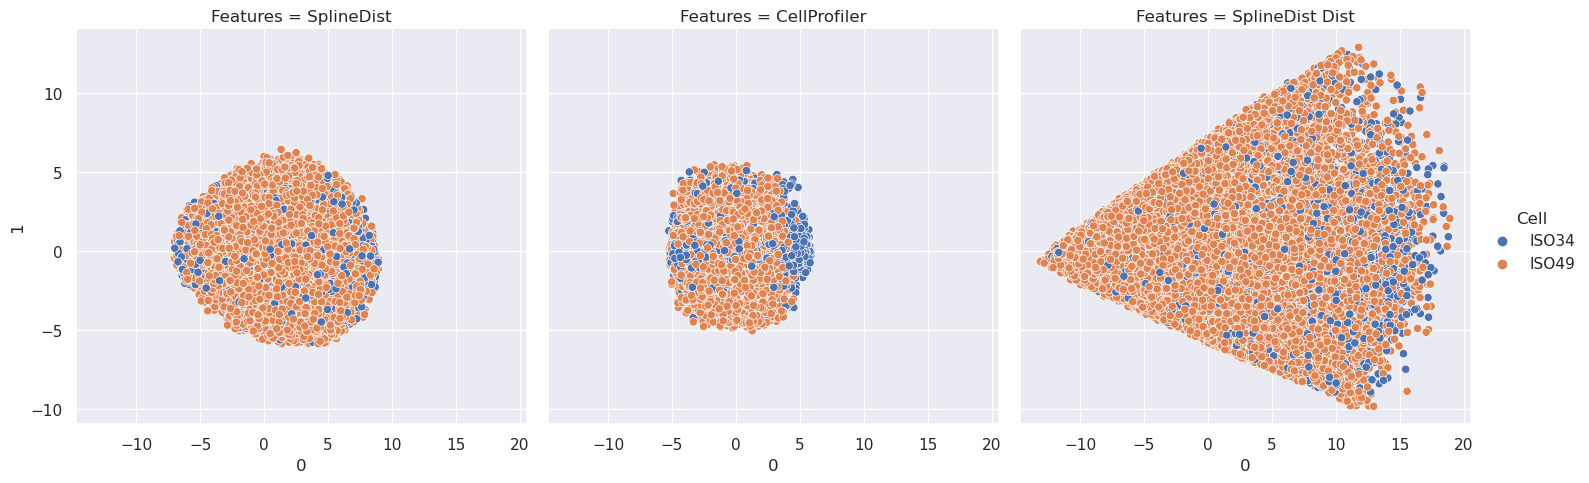

In [8]:

pca_splinedist_df = df_splinedist.pipe(pca_fun, pca_spline)
pca_cellprofiler_df = df_cellprofiler.pipe(pca_fun, pca_cellprofiler)
pca_distance_matrix_df = df_distance_matrix.pipe(pca_fun)

pca_df = pd.concat([pca_splinedist_df, pca_cellprofiler_df, pca_distance_matrix_df])

sns.relplot(data=pca_df, x=0, y=1, col="Features", hue="Cell")

exp_var = pd.concat(
    [
        pd.DataFrame(
            pca_spline.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(
                    0, len(pca_spline.explained_variance_)
                ),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "CellProfiler",
                "Principal Component": np.arange(
                    0, len(pca_cellprofiler.explained_variance_)
                ),
            }
        ),
    ]
)

pca_component = pd.concat(
    [
        pd.DataFrame(pca_spline.components_, columns=df_splinedist.columns).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(0, len(pca_spline.components_)),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.components_, columns=df_cellprofiler.columns
        ).assign(
            **{
                "Features": "CellProfiler",
                "Principal Component": np.arange(0, len(pca_cellprofiler.components_)),
            }
        ),
    ]
).set_index(["Features", "Principal Component"])

results/merged/pca.pdf


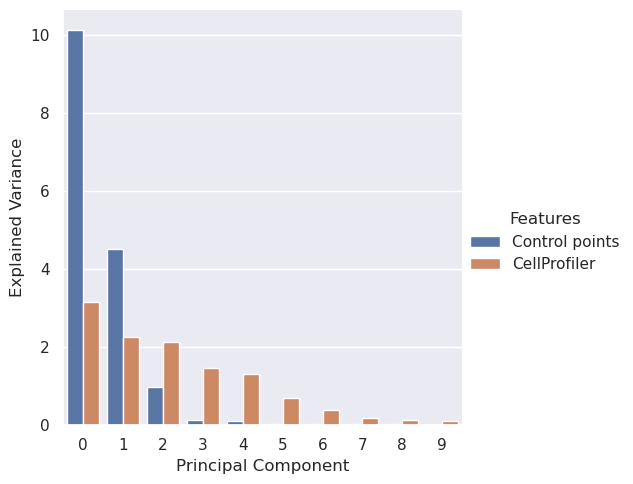

In [9]:
# plt.figure()
sns.catplot(
    x="Principal Component",
    hue="Features",
    y="Explained Variance",
    data=exp_var,
    legend_out=True,
    kind="bar",
)
plt.savefig(metadata("pca.pdf"), bbox_inches="tight")


In [10]:
component_melt = pd.melt(
    pca_component,
    var_name="Feature",
    value_name="Component Magnitude",
    ignore_index=False,
).set_index(["Feature"], append=True)


important_features = (
    component_melt.transform(abs)
    .reset_index()
    .sort_values("Component Magnitude", ascending=False)
    .drop_duplicates(["Features", "Principal Component"])
    .sort_values("Principal Component")
)


In [11]:
# sns.catplot(
#     x="Principal Component",
#     y="Feature",
#     data=important_features.reset_index(),
#     col="Features",
#     sharey=False,
# )


In [12]:

# sns.catplot(
#     col="Principal Component",
#     y="Feature",
#     x="Component Magnitude",
#     sharey=False,
#     data=component_melt.reset_index(),
#     row="Features",
#     height=12,
# )

Organoids: 515 Nuclei: 37235
results/merged/fingerprints.pdf


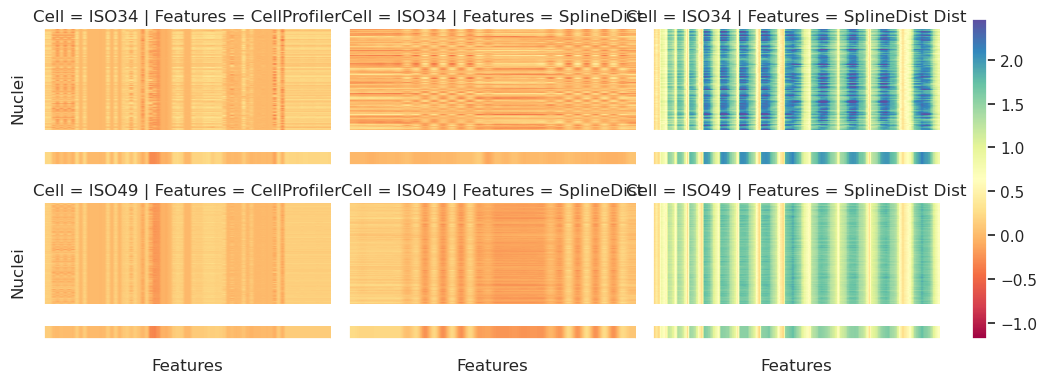

In [13]:
# df = df.iloc[:,random.sample(range(0, features), 32)]

print(
    f'Organoids: {df.cellesce.grouped_median("ObjectNumber").cellesce.simple_counts()}',
    f"Nuclei: {df.cellesce.simple_counts()}",
)

upper = np.nanmean(df.values.flatten()) + 2 * np.nanstd(df.values.flatten())
lower = np.nanmean(df.values.flatten()) - 2 * np.nanstd(df.values.flatten())


def df_to_fingerprints_facet(*args, **kwargs):
    data = kwargs.pop("data")
    data = data.drop([*args[2:]], 1)

    image = data.dropna(axis=1, how="all")

    rows, cols = image.shape
    median_height = 0.1
    gap_height = 0.15
    # median_rows = int(rows*median_height/100)
    image_rows_percent = 1 - (gap_height + median_height)
    one_percent = rows / image_rows_percent
    # print(one_percent,rows)
    gap_rows = int(gap_height * one_percent)
    median_rows = int(median_height * one_percent)

    # median_rows,gaps_rows=(rows,rows)
    finger_print = image.median(axis=0)

    finger_print_image = np.matlib.repmat(finger_print.values, median_rows, 1)
    all_data = np.vstack([image, np.full([gap_rows, cols], np.nan), finger_print_image])

    # fig,ax = plt.subplots(figsize=(5,3), dpi=150)
    # fig, ax = plt.figure(figsize=(5,3), dpi=150)
    # plt.figure()
    plt.imshow(all_data, vmin=lower, vmax=upper, cmap="Spectral")
    # sns.heatmap(all_data,vmin=lower, vmax=upper, cmap="Spectral",interpolation='nearest')
    fig, ax = (plt.gcf(), plt.gca())
    ax.set(adjustable="box", aspect="auto", autoscale_on=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor("white")
    ax.grid(False)
    # fig.add_subplot(2,2,1)


sns.set()
g = sns.FacetGrid(
    df.reset_index(level=["Cell", "Features"]),
    col="Features",
    row="Cell",
    height=2,
    aspect=1.61,
    sharey=False,
    sharex=False,
)
cax = g.fig.add_axes([1.015, 0.13, 0.015, 0.8])
g.map_dataframe(
    df_to_fingerprints_facet,
    "Features",
    "Nuclei",
    "Features",
    "Cell",
    cmap="Spectral",
    cbar=True,
    vmax=upper,
    vmin=lower,
)
plt.colorbar(cax=cax)
plt.savefig(metadata("fingerprints.pdf"), bbox_inches="tight")
# plt.show();plt.close()

In [14]:


# df_distance_matrix = (df_splinedist
#                       .pipe(df_to_distance_matrix)
#                       .pipe(augment_distance_matrix,axis=1))


# df = pd.concat([df_cellprofiler, df_splinedist])

# df = pd.concat([df_cellprofiler,
#                 df_splinedist.pipe(df_to_distance_matrix)])


# df = pd.concat([df_cellprofiler
#                     .pipe(augment_repeat, fold=1),
#                 df_splinedist
#                     .pipe(df_to_distance_matrix)
#                     .pipe(augment_distance_matrix)
#                     .pipe(df_add_augmentation_index)])

In [15]:
# TODO



In [16]:


def feature_importances(df, augment=None):
    return (
        df.cellesce.grouped_median("ObjectNumber")
        .dropna(axis=1)
        .cellesce.feature_importances(variable="Cell", kfolds=10, augment=augment)
    ).assign(Augmentation=augmentation)


def scoring(df, augment=None):
    return (
        df.cellesce.grouped_median("ObjectNumber")
        .dropna(axis=1)
        .cellesce.get_scoring_df(variable="Cell", kfolds=10, augment=augment)
    ).assign(Augmentation=augmentation)


importance_list = []
scoring_list = []

for augmentation in tqdm([0, 250, 500, 1000]):

    # for fold in range(1,6):

    # df = pd.concat(
    #     [
    #         df_cellprofiler.pipe(augment_repeat, fold=fold).pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points, fold=fold).pipe(
    #             df_add_augmentation_index
    #         ),
    #     ]
    # )
    # df = pd.concat(
    #     [
    #         df_cellprofiler.pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points, fold=augmentation)
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # dask_spline_df = dd.from_pandas(df_splinedist.reset_index(),npartitions=1)

    # temp_df = df_splinedist.cellesce.grouped_median("ObjectNumber")
    # temp_df.loc[:,:] = 1
    # df = pd.concat(
    #     [
    #         # df_splinedist.pipe(rotate_control_points,fold=10)
    #         df_cellprofiler.pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points_np, fold=augmentation),
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # df = pd.concat(
    #     [
    #         # df_splinedist.pipe(rotate_control_points,fold=10)
    #         df_cellprofiler,
    #         df_splinedist
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # df_cellprofiler_rep = df_cellprofiler.reindex(df_cellprofiler.index.repeat(3)).pipe(
    #     df_add_augmentation_index
    # )

    # df = df_cellprofiler_rep
    # feature_importance = df.groupby(level="Features").apply(
    #     lambda df: df.cellesce.grouped_median("ObjectNumber")
    #     .dropna(axis=1)
    #     .cellesce.feature_importances(variable="Cell",kfolds=5,groupby="augmentation")
    # ).assign(Augmentation=augmentation)

    spline_augment = lambda X, y: shapes.angular_augment_X_y(
        X, y, shapes.rotate_control_points_np, fold=augmentation
    )

    # df_splinedist.pipe(feature_importances,augment=spline_augment)

    # feature_importance_df = pd.concat(
    #     [df_cellprofiler.pipe(feature_importances),
    #      df_splinedist.pipe(feature_importances,augment=angular_augment_X_y)])
    # TODO this isnt augmenting
    feature_importance_df = pd.concat(
        [
            (
                df_cellprofiler.cellesce.grouped_median("ObjectNumber")
                .pipe(feature_importances)
                .assign(Features="CellProfiler")
                .set_index("Features", append=True)
            ),
            (
                df_splinedist.cellesce.grouped_median("ObjectNumber")
                .pipe(
                    feature_importances,
                    augment=shapes.angular_augment_X_y_fun(fold=augmentation),
                )
                .assign(Features="SplineDist")
                .set_index("Features", append=True)
            ),
        ]
    )

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       ISO34       0.67      0.70      0.69        47
       ISO49       0.82      0.80      0.81        82

    accuracy                           0.77       129
   macro avg       0.75      0.75      0.75       129
weighted avg       0.77      0.77      0.77       129

0.5024427873489329
              precision    recall  f1-score   support

       ISO34       0.83      0.72      0.77        47
       ISO49       0.85      0.91      0.88        82

    accuracy                           0.84       129
   macro avg       0.84      0.82      0.83       129
weighted avg       0.84      0.84      0.84       129

0.6559082421979194
              precision    recall  f1-score   support

       ISO34       0.82      0.60      0.69        47
       ISO49       0.80      0.93      0.86        82

    accuracy                           0.81       129
   macro avg       0.81      0.76      0.78       129
weighted avg       0.81      0.81   

 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

              precision    recall  f1-score   support

       ISO34       0.87      0.89      0.88        45
       ISO49       0.94      0.93      0.93        83

    accuracy                           0.91       128
   macro avg       0.90      0.91      0.91       128
weighted avg       0.91      0.91      0.91       128

0.8124667021843367
              precision    recall  f1-score   support

       ISO34       0.79      0.76      0.77        45
       ISO49       0.87      0.89      0.88        83

    accuracy                           0.84       128
   macro avg       0.83      0.82      0.83       128
weighted avg       0.84      0.84      0.84       128

0.6537733297268056
              precision    recall  f1-score   support

       ISO34       0.67      0.68      0.67        47
       ISO49       0.81      0.80      0.81        82

    accuracy                           0.76       129
   macro avg       0.74      0.74      0.74       129
weighted avg       0.76      0.76   

 50%|█████     | 2/4 [01:46<02:04, 62.08s/it]

              precision    recall  f1-score   support

       ISO34       0.76      0.76      0.76        45
       ISO49       0.87      0.87      0.87        83

    accuracy                           0.83       128
   macro avg       0.81      0.81      0.81       128
weighted avg       0.83      0.83      0.83       128

0.6230254350736278
              precision    recall  f1-score   support

       ISO34       0.73      0.68      0.70        47
       ISO49       0.82      0.85      0.84        82

    accuracy                           0.79       129
   macro avg       0.78      0.77      0.77       129
weighted avg       0.79      0.79      0.79       129

0.5418913586742076
              precision    recall  f1-score   support

       ISO34       0.82      0.70      0.76        47
       ISO49       0.84      0.91      0.88        82

    accuracy                           0.84       129
   macro avg       0.83      0.81      0.82       129
weighted avg       0.84      0.84   

 75%|███████▌  | 3/4 [05:15<02:08, 128.93s/it]

              precision    recall  f1-score   support

       ISO34       0.80      0.78      0.79        45
       ISO49       0.88      0.89      0.89        83

    accuracy                           0.85       128
   macro avg       0.84      0.83      0.84       128
weighted avg       0.85      0.85      0.85       128

0.6727664155005382
              precision    recall  f1-score   support

       ISO34       0.67      0.66      0.67        47
       ISO49       0.81      0.82      0.81        82

    accuracy                           0.76       129
   macro avg       0.74      0.74      0.74       129
weighted avg       0.76      0.76      0.76       129

0.478821842825492
              precision    recall  f1-score   support

       ISO34       0.80      0.68      0.74        47
       ISO49       0.83      0.90      0.87        82

    accuracy                           0.82       129
   macro avg       0.82      0.79      0.80       129
weighted avg       0.82      0.82    

100%|██████████| 4/4 [12:29<00:00, 187.49s/it]

              precision    recall  f1-score   support

       ISO34       0.80      0.73      0.77        45
       ISO49       0.86      0.90      0.88        83

    accuracy                           0.84       128
   macro avg       0.83      0.82      0.82       128
weighted avg       0.84      0.84      0.84       128

0.6501776441650724


In [17]:
    scoring_df = pd.concat(
        [
            (
                df_cellprofiler.cellesce.grouped_median("ObjectNumber")
                .pipe(scoring)
                .assign(Features="CellProfiler")
                .set_index("Features", append=True)
            ),
            (
                df_splinedist.cellesce.grouped_median("ObjectNumber")
                .pipe(scoring, augment=shapes.angular_augment_X_y)
                .assign(Features="SplineDist")
                .set_index("Features", append=True)
            ),
        ]
    )

    importance_list.append(feature_importance_df)
    scoring_list.append(scoring_df)

    # feature_importance = (
    #     df.groupby(level="Features").apply(
    #         lambda df: df.cellesce.grouped_median("ObjectNumber")
    #         .dropna(axis=1)
    #         .cellesce.feature_importances(
    #             variable="Cell", kfolds=10, groupby="augmentation"
    #         )
    #     )
    # ).assign(Augmentation=augmentation)

    # scoring = (
    #     df.groupby(level="Features").apply(
    #         lambda df: df.cellesce.grouped_median("ObjectNumber")
    #         .dropna(axis=1)
    #         .cellesce.get_scoring_df(variable="Cell", kfolds=10, groupby="augmentation")
    #     )
    # ).assign(Augmentation=augmentation)


scoring_df = pd.concat(scoring_list)
importance_df = pd.concat(importance_list)


scoring_df_mean = scoring_df.groupby(
    ["Augmentation", "Metric", "Kind", "Variable"]
).mean()
scoring_df_var = scoring_df.groupby(
    ["Augmentation", "Metric", "Kind", "Variable"]
).var()



results/merged/scoring.pdf


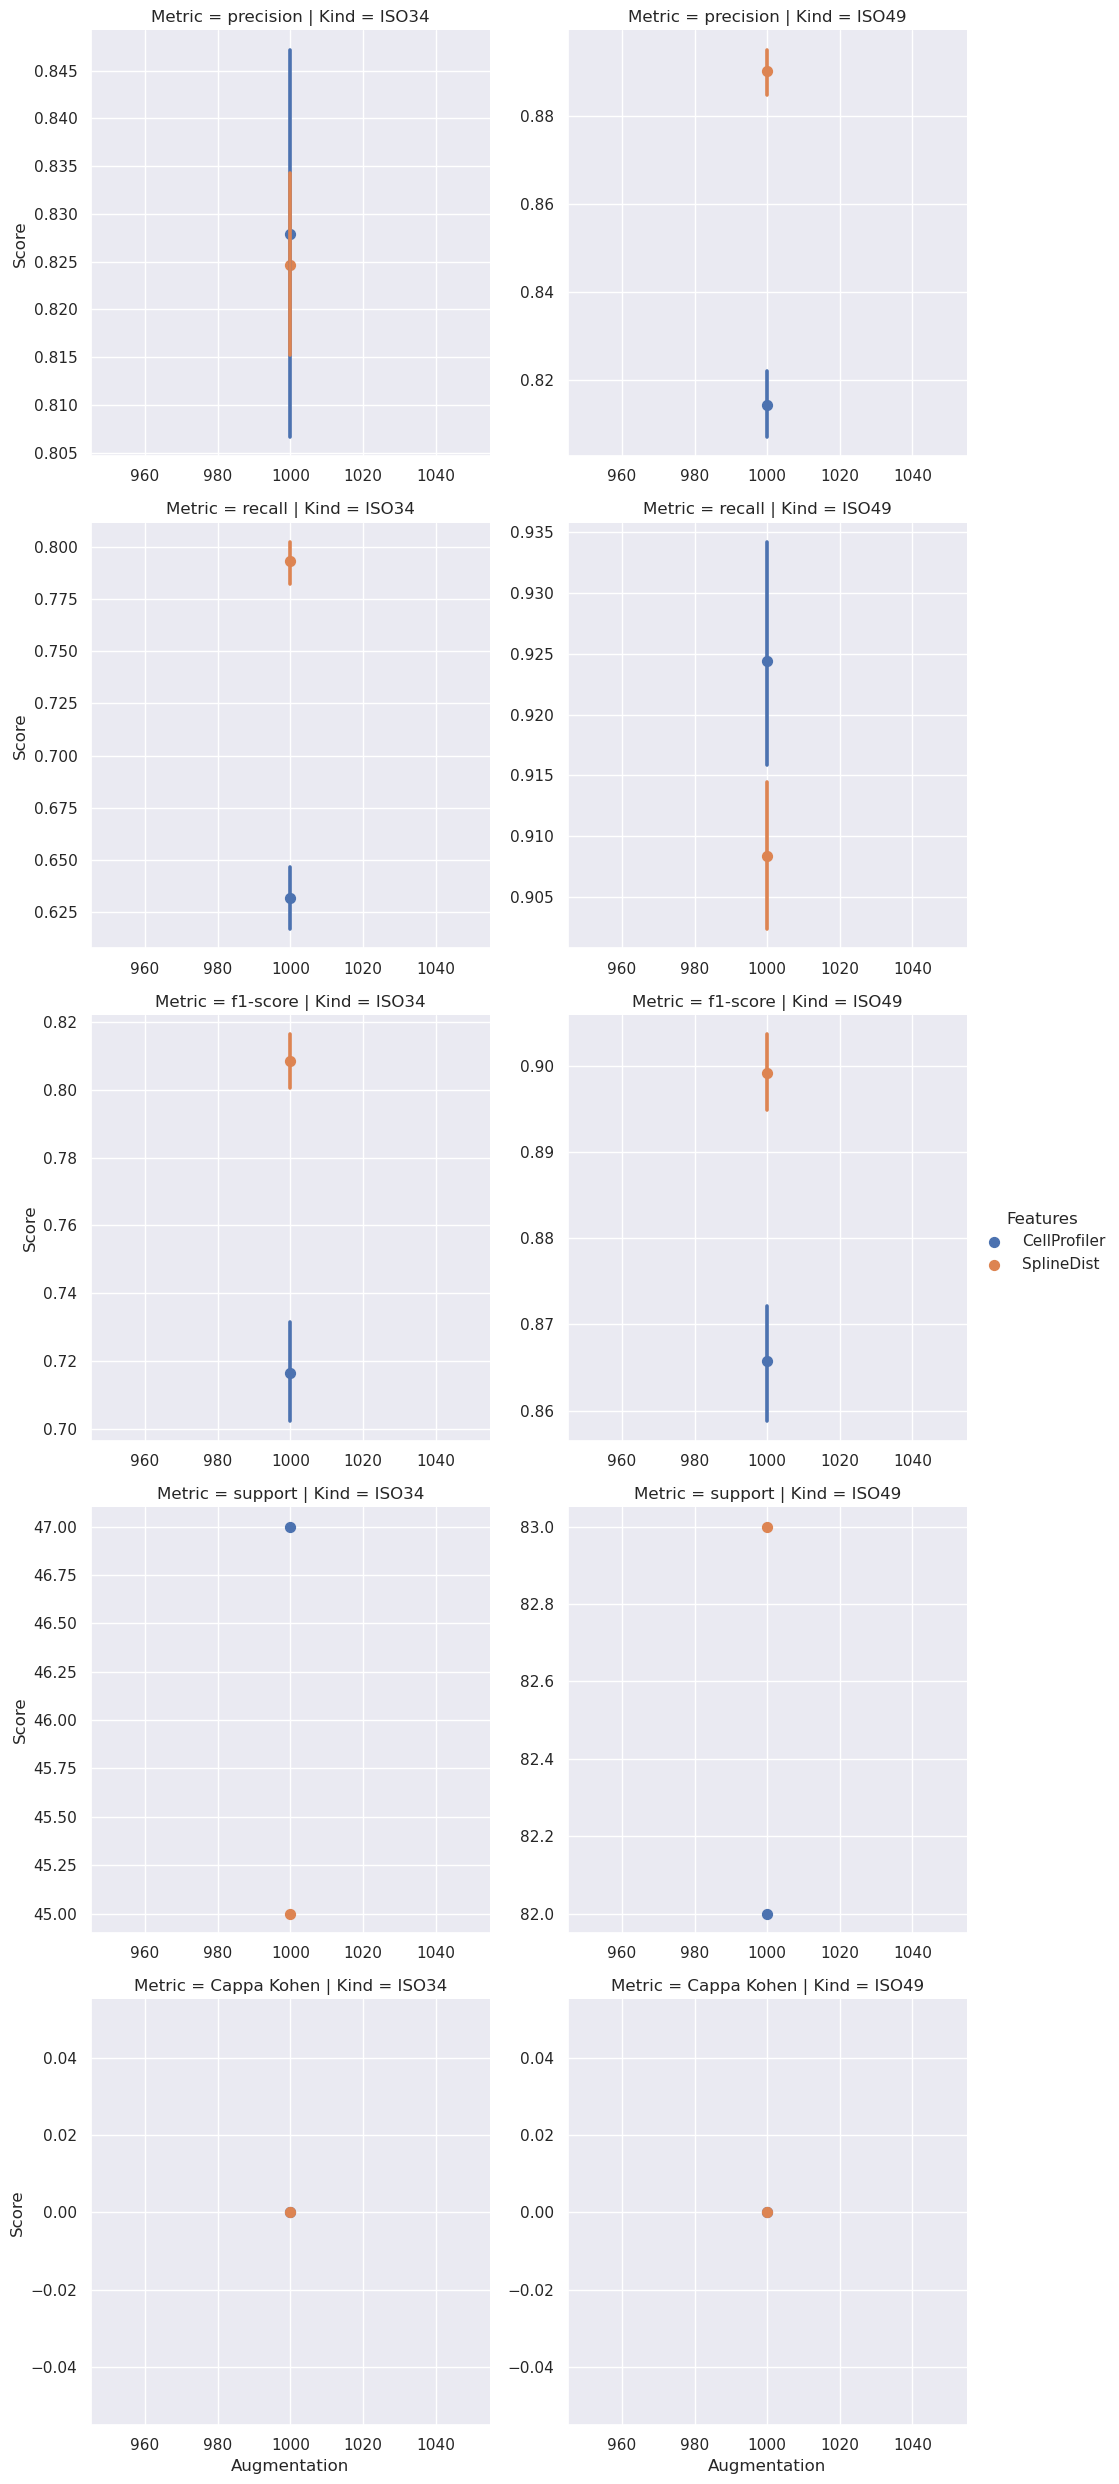

In [18]:
# data = scoring_df.reset_index("Features")
# data.to_csv("scoring_df.csv")
sns.lmplot(
    x="Augmentation",
    y="Score",
    col="Kind",
    row="Metric",
    hue="Features",
    fit_reg=False,
    sharey=False,
    sharex=False,
    x_ci="ci",
    x_bins=5,
    data=(scoring_df.reset_index("Features")),
)
plt.savefig(metadata("scoring.pdf"))

results/merged/feature_importance.pdf


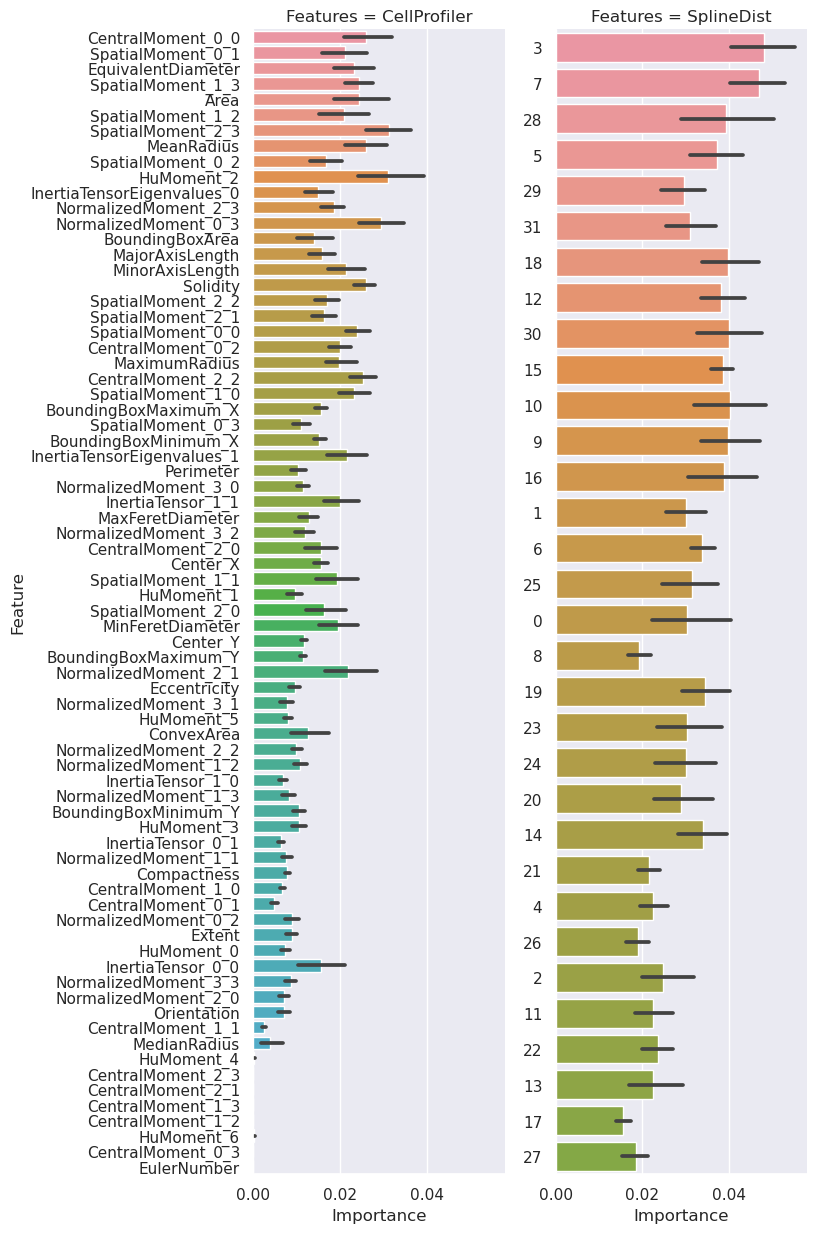

In [19]:
# plt.show();plt.close()

sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=(importance_df.reset_index()),
)
plt.savefig(metadata("feature_importance.pdf"))

# plt.show();plt.close()



In [20]:
# TODO figure how to add after data splitting

# df = (
#     df_cellprofiler.pipe(augment_repeat, fold=fold)
#     .pipe(df_add_augmentation_index)
#     .cellesce.grouped_median("ObjectNumber")
#     .dropna(axis=1)
# )

# df = (df_splinedist
#     .pipe(augment_df, rotate_control_points, fold=5)
#     .pipe(df_add_augmentation_index))

# groupby = list(set(df.index.names)-{"augmentation"})

# y = df.reset_index()[["Cell"]].astype(str)
# X_train, X_test, y_train, y_test = df.cellesce.train_test_split(
#     variable="Cell", groupby=["augmentation"], seed=42)
# # (RandomForestClassifier()
# #         .fit(X_train,
# #              y_train)
# #         .score(X_test.xs(0,level="augmentation"),
# #                y_test.xs(0,level="augmentation")))

# score = (RandomForestClassifier()
#         .fit(X_train,y_train)
#         .score(X_test,y_test))
# print(f"fold {fold} score {score}")



              precision    recall  f1-score   support

       ISO34       0.71      0.68      0.70        47
       ISO49       0.82      0.84      0.83        82

    accuracy                           0.78       129
   macro avg       0.77      0.76      0.76       129
weighted avg       0.78      0.78      0.78       129

0.5271013354281225
              precision    recall  f1-score   support

       ISO34       0.76      0.87      0.81        45
       ISO49       0.92      0.86      0.89        83

    accuracy                           0.86       128
   macro avg       0.84      0.86      0.85       128
weighted avg       0.87      0.86      0.86       128

0.700701480904131
              precision    recall  f1-score   support

       ISO34       0.81      0.87      0.84        45
       ISO49       0.93      0.89      0.91        83

    accuracy                           0.88       128
   macro avg       0.87      0.88      0.87       128
weighted avg       0.89      0.88    

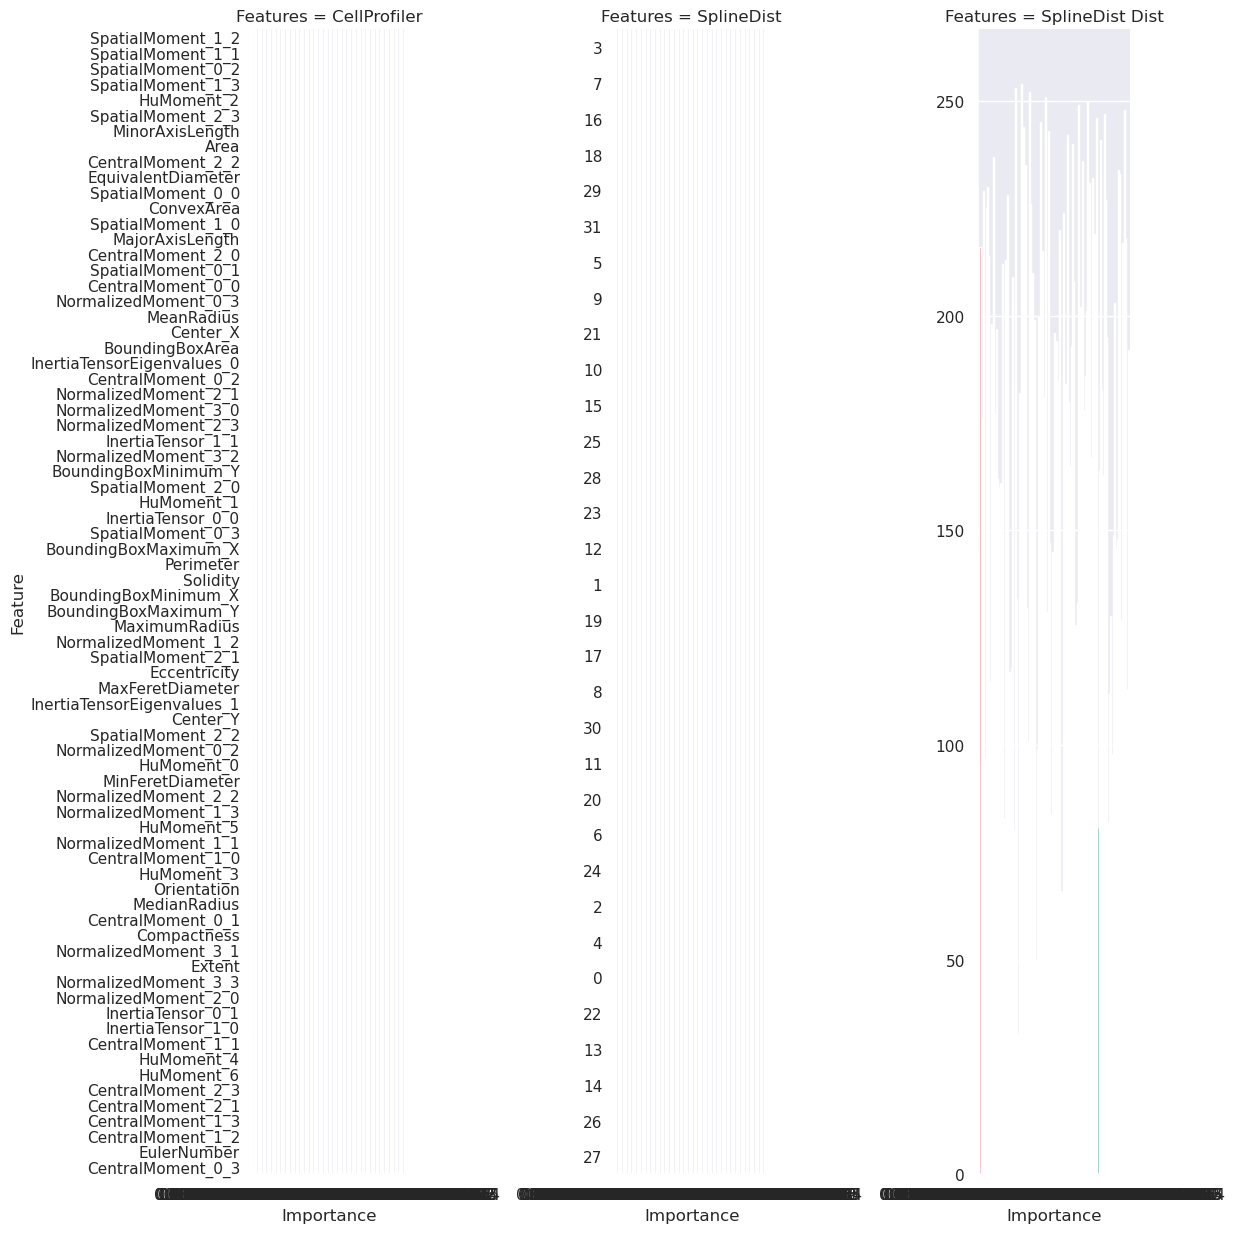

In [21]:
data = (
    (
        df.groupby(level="Features").apply(
            lambda df: df.cellesce.grouped_median()
            .dropna(axis=1)
            .cellesce.feature_importances(variable="Cell")
        )
    )
    .reset_index()
    .pipe(save_csv, "importance_median_control_points.csv")
)
sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=data,
)

# plt.tight_layout()
plt.savefig(metadata("importance_median_control_points.pdf"))



In [22]:

# sample = -1

spline_importances = importance_df.xs("SplineDist", level="Features")["Importance"]

cellprofiler_importances = importance_df.xs("CellProfiler", level="Features")[
    "Importance"
]

spline_H = scipy.stats.entropy(
    spline_importances, qk=np.ones_like(spline_importances) / len(spline_importances)
)
spline_H

cellprofiler_H = scipy.stats.entropy(
    cellprofiler_importances,
    qk=np.ones_like(cellprofiler_importances) / len(cellprofiler_importances),
)
cellprofiler_H

# scipy.stats.ks_2samp(
    # cellprofiler_importances,
    # np.ones_like(cellprofiler_importances)/len(cellprofiler_importances)
    # )

# scipy.stats.ks_2samp(
    # spline_importances,
    # np.ones_like(spline_importances)/len(spline_importances))

spline_test = scipy.stats.normaltest(importance_df.xs("SplineDist", level="Features"))
cellprofiler_test = scipy.stats.normaltest(
    importance_df.xs("CellProfiler", level="Features")
)
print(f"Spline: {spline_H} CellProfiler: {cellprofiler_H}")
print(f"Spline: {spline_test.pvalue[0]} CellProfiler: {cellprofiler_test.pvalue[0]}")


Spline: 0.08180052590086553 CellProfiler: 0.2735726773773094
Spline: 1.7933798860390134e-05 CellProfiler: 7.529952046469466e-20


In [23]:
# sns.barplot(
#     y="Feature", x="Cumulative Importance",
#     data=df.cellesce.feature_importances(variable="Cell").reset_index()
# )
# plt.tight_layout()



In [24]:
#     data=(
#         pd.concat(
#         [(
#             df.cellesce.grouped_median("ObjectNumber")
#             .cellesce.get_score_report("Cell")
#             .assign(**{"Population type": "Organoid"})
#             .set_index("Metric")
#             .loc[['f1-score', 'recall','precision']]
#             .reset_index()
#             .assign(Fold=fold)
#             .pipe(save_csv,"Cell_predictions_organoid.csv")
#             )
#         for fold in range(5)]
#     )),
# data =  pd.concat([
#         (pd.concat(
#         [
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Nuclei"})
#             ),
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#             ),
#         ])
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']])
#         .reset_index()
#         .assign(Fold=fold) for fold in range(5)
#         ]).pipe(save_csv,"Cell_predictions_image_vs_nuclei.csv")

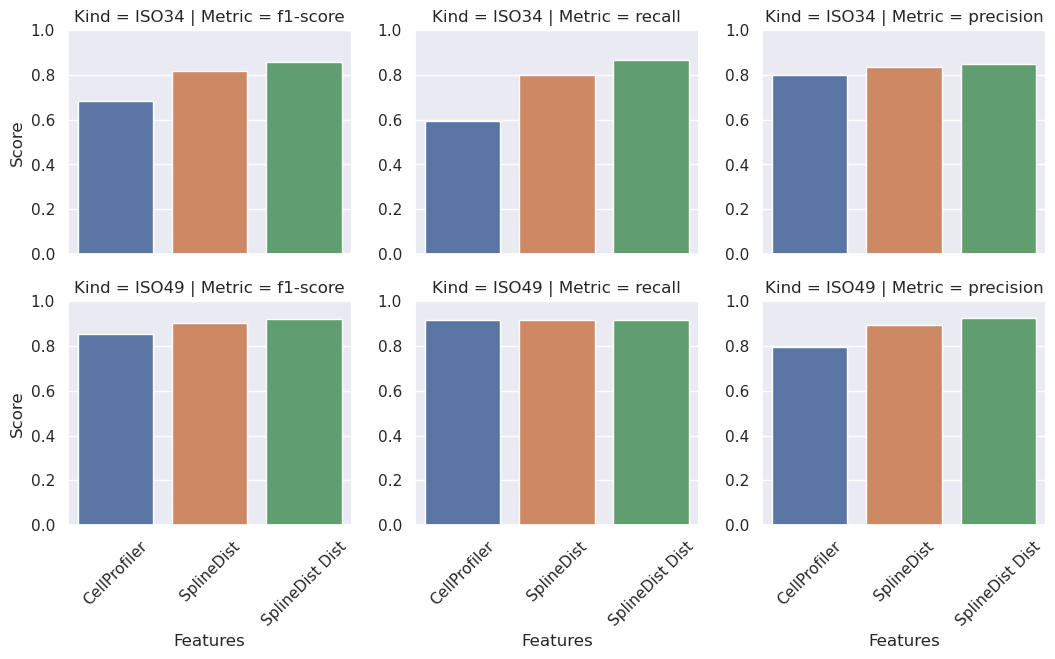

In [25]:


# No augmentation
# df = pd.concat([df_cellprofiler, df_splinedist])

# Distance matrix method
# df = pd.concat([df_cellprofiler, df_splinedist.pipe(df_to_distance_matrix)])
# df = pd.concat(
#     [
#         df_cellprofiler.reindex(df_cellprofiler.index.repeat(100)).pipe(
#             df_add_augmentation_index
#         ),
#         df_splinedist.pipe(augment_df, rotate_control_points, fold=100).pipe(
#             df_add_augmentation_index
#         ),
#     ]
# )


# df_cellprofiler_rep = df_cellprofiler.reindex(df_cellprofiler.index.repeat(100)).pipe(df_add_augmentation_index)
# df_cellprofiler_rep.pipe(df_add_augmentation_index)

# pd.MultiIndex.from_arrays([df.index, df.groupby(level=0).cumcount()],
#                                      names=(list(df.index.names) + ["Augment"]))
# options = {
#     "raw": pd.concat([df_cellprofiler, df_splinedist]),
#     "distance_matrix": pd.concat(
#         [df_cellprofiler, df_splinedist.pipe(df_to_distance_matrix)]
#     ),
#     "angular_augment": pd.concat(
#         [
#             df_cellprofiler,
#             df_splinedist.pipe(augment_df, rotate_control_points, fold=10),
#         ]
#     ),
# }

# df = options["angular_augment"]


def get_score_report_per_level(df, level="Features"):
    return (
        df.groupby(level="Features")
        .apply(
            lambda df: df.cellesce.grouped_median()
            .dropna(axis=1)
            .cellesce.get_score_report(variable="Cell")
        )
        .reset_index()
        .set_index("Metric")
        .loc[["f1-score", "recall", "precision"]]
        .reset_index()
    )


(
    sns.catplot(
        aspect=1.2,
        height=3,
        x="Features",
        y="Score",
        col="Metric",
        row="Kind",
        # ci=None,
        data=df.pipe(shapes.get_score_report_per_level, "Features"),
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)


In [26]:
df = pd.concat([df_cellprofiler, df_splinedist])


def score_report_per_row(df, variable="Cell"):
    return df.groupby(level="Features").apply(
        lambda df: df.dropna(axis=1).cellesce.get_score_report(variable=variable)
    )


def score_report_per_group(df, variable="Cell", group="ObjectNumber"):
    return df.groupby(level="Features").apply(
        lambda df: df.cellesce.grouped_median(group)
        .dropna(axis=1)
        .cellesce.get_score_report(variable=variable)
    )


def get_score_report_per_with_error(df, fold, variable="Cell"):
    return (
        pd.concat(
            [
                score_report_per_row(df, "Cell").assign(
                    **{"Population type": "Nuclei"}
                ),
                score_report_per_group(df, "Cell").assign(
                    **{"Population type": "Organoid"}
                ),
            ]
        )
        .reset_index()
        .set_index("Metric")
        .loc[["f1-score", "recall", "precision"]]
        .reset_index()
        .assign(Fold=fold)
    )


data_list = []
pbar = tqdm(range(5))
for fold in pbar:
    pbar.set_description(f"Folding:")
    data_list.append(get_score_report_per_with_error(df, fold))

data = pd.concat(data_list).pipe(save_csv, "Cell_predictions_image_vs_nuclei.csv")

Folding:: 100%|██████████| 5/5 [11:08<00:00, 133.60s/it]

results/merged/Cell_predictions_image_vs_nuclei.csv


results/merged/Cell_predictions_image_vs_nuclei.pdf
results/merged/Cell_predictions_organoid.pdf


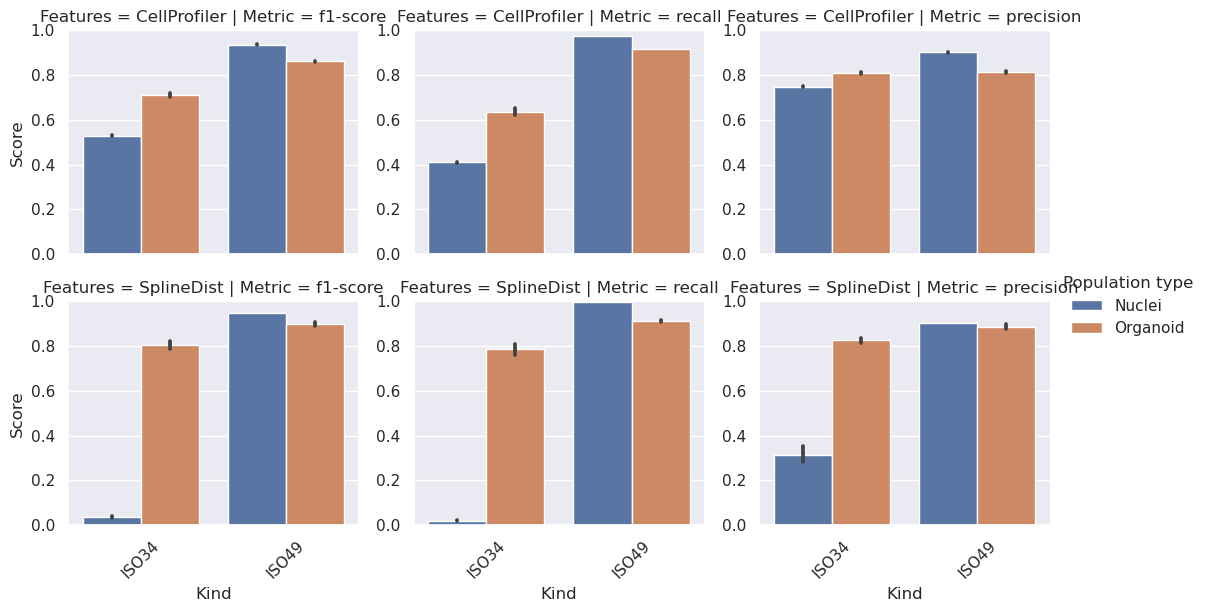

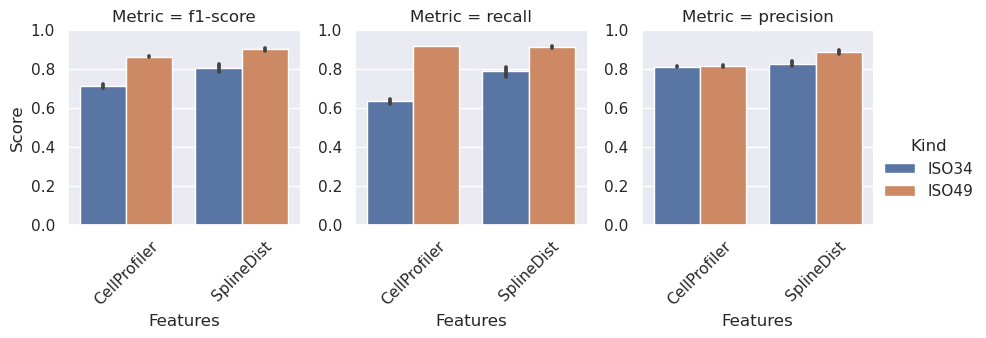

In [27]:
(
    sns.catplot(
        aspect=1.2,
        height=3,
        x="Kind",
        y="Score",
        col="Metric",
        row="Features",
        # ci=None,
        hue="Population type",
        data=data,
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)

# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_image_vs_nuclei.pdf"))

(
    sns.catplot(
        aspect=1,
        height=3,
        x="Features",
        y="Score",
        col="Metric",
        hue="Kind",
        # ci=None,
        data=data.set_index("Population type").loc["Organoid"],
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)
# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_organoid.pdf"), bbox_inches="tight")


In [28]:


# df_temp = ((df.groupby(level="Features")
#                 .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']]
#         .reset_index())
# data_list.append(df_temp)

In [29]:
import os

print("Exporting to notebook")
os.system(f"jupytext --to notebook splines.py --update --execute")


Exporting to notebook


sh: line 1: jupytext: command not found


32512